# Notebook 04b: Modeling - GloVe Embeddings

## Contents:
1. [Summary](#section1)
2. [Embeddings](#section2)
3. [Building the Model](#section3)
4. [Model Fitting](#section4)
4. [Assessing the Model](#section5)
5. [Generating Lyrics](#section6)

# Summary<a name="section1"></a>
In this notebook build on the previous notebook using word embeddings, however I will utilize pre-trained word vectors from the GloVe Common Crawl 42B 300d dataset. This will be interesting to compare with the learned, Keras generated embeddings as these pre-trained vectors should have a much stronger relationship based on the size of the training corpus.

In [3]:
import json, time, re, string, keras, pickle, h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import random
from scipy.sparse import coo_matrix
from scipy import sparse

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint


%matplotlib inline
plt.style.use('fivethirtyeight')

%run ../assets/sql_cred.py

In [2]:
print(tf.test.gpu_device_name())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [3]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[0-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

In [4]:
X_reshape = np.load('../assets/1549351379_LSTM350_Xreshape.npy')

In [5]:
y_cat_coo = sparse.load_npz('../assets/1549351379_LSTM350_ycat.npz')

In [6]:
y_cat = y_cat_coo.toarray()

In [7]:
with open('../models/1549351379_LSTM350_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

In [9]:
vocab_size

12978

## Embeddings<a name="section2"></a>

Loading the GloVe embeddings. This will create a dict from the embeddings .txt file that can be used to map the dataset into prio to model training.

In [10]:
embeddings_index = dict()

f = open('../glove_data/glove.42B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print(f'Loaded {len(embeddings_index)} word vectors')

Loaded 483569 word vectors


There were 438k words present in the GloVe dataset.

Mapping the lyric vocabulary into the embedding space, producing an embedding matrix that is scaled to our vocab_size.

In [11]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
len(embedding_matrix)

12978

## Building the Model<a name="section3"></a>
This model is largely similar to the previous architecture with a couple exceptions. Here, we are explicitly setting the embedding layer weights to correspond to the GloVe embeddings matrix. We also have the option of allowing this to be trainable or not trainable by the model. The first run will be performed with the embeddings fixed at the GloVe values.

Note, the input LSTM and second LSTM layers have been changed for a second run and the embeddings layer has been set to allow training of the embedding weights. This is in response to results from the first run that produced high repetition and low variation, an effect we would expect with more confident predictions. By broadening the model it's hoped that the model will become more sensitve to the structure and semantic nuances of song lyrics.

In [14]:
seq_len=4

# Compile model
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=seq_len, mask_zero=True, trainable=True))
model.add(LSTM(600, return_sequences=True))
model.add(LSTM(300))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

## Model Fitting<a name="section4"></a>

In tandem with the above changes to broaden the model, we will also decrease the batch size and increase the number of epochs, allowing the model to train more deeply on the dataset. (Note, output cleared after incomplete run)

In [ ]:
# Train model on dataset
with tf.device('/gpu:0'):
    history = model.fit(X_reshape,
              y_cat,
              verbose=1,
              batch_size=2500,
              epochs=600, 
             )

formatted_name, now, file_description= filename_format_log('../models/LSTM625_42Bmodel.h5')

model.save(formatted_name)

In [ ]:
# model = keras.models.load_model('../assets/1549265762_LSTM_Model.h5')

## Assessing the Model<a name="section5"></a>

In [15]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 300)            3893400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 12978)             1310778   
Total params: 6,211,078
Trainable params: 2,317,678
Non-trainable params: 3,893,400
_________________________________________________________________
None


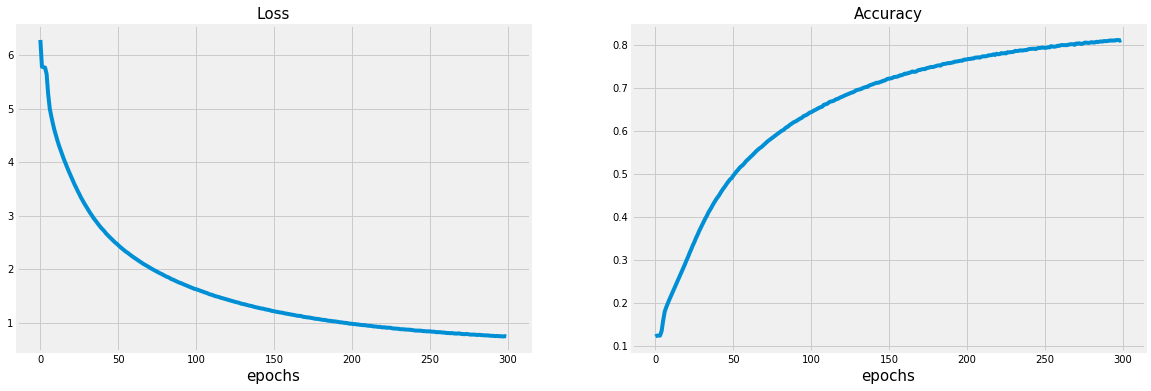

In [16]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss", fontsize=15);
ax[0].set_xlabel("epochs",fontsize=15);

ax[1].plot(history.history['acc'])
ax[1].set_title("Accuracy",fontsize=15);
ax[1].set_xlabel("epochs",fontsize=15);

The previous run does not seem to have reached its max accuracy or min loss, suggesting it can run for more epochs

## Generating Lyrics<a name="section6"></a>

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [46]:
def generate_lyrics(seed, 
                    seq_len = 4, 
                    song_len = 50,
                    temperature = 1.0,
                    model_dir = None):
    
    if model_dir:
        model = keras.models.load_model(f'{model_dir}/*.h5')
        
        with open(f'{model_dir}/*.pkl', 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        model = model

        tokenizer = tokenizer
    
    seed_clean = seed.lower().split(' ')
    doc = []

    while len(doc) < song_len:
        text = [seed_clean]
        sequence = [tokenizer.texts_to_sequences([word])[0] for word in text]
        pad_sequence = pad_sequences(sequence, maxlen=seq_len, truncating='pre')
        sequence_reshape = np.reshape(pad_sequence, (1, seq_len))

        yhat = model.predict(sequence_reshape, verbose=0)[0]
        next_index = sample(yhat, temperature)
        
        for word, index in tokenizer.word_index.items():
            if index == next_index:
                seed_clean.append(word)
                doc.append(word)

    return ' '.join(doc)

In [4]:
def lyric_grid(track):
#     track = df.loc[track_id, 'clean_lyrics']
    
    lyrics_spaced = re.sub(r'( +)', ' ', track)
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    
    N = len(lyrics_split)
    grid = np.zeros(shape=(N,N), dtype='int')
    
    for i in range(N):
        hits = [j for j, word in enumerate(lyrics_split) if word == lyrics_split[i]]
        grid[i,[hits]] = 1 
    
    plt.figure(figsize=(16,12))
    plt.title('Repetition in Track');
    plt.xlabel('Word Number');
    plt.ylabel('Word Number');
    sns.heatmap(grid, cmap='Greys', cbar=False, xticklabels=[], yticklabels=[]);
    
    plt.show();
    
    rep_ratio = np.around(((N - len(set(lyrics_split))) / N), 2)
    
    print('\n')
    print(f'The repetition ratio for this track is {rep_ratio}')
    print('\n')
    print(track)
    return 

In [19]:
lyrics = generate_lyrics('always be there love',
                         seq_len=4,
                         song_len=250,
                         model_dir=None,
                        )
print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



 and i wanna fall in love over subtweets woowoowoowoooo your lines are gonna feel these plans oh love 
 let me be the one you doesnt be there hello 
 i wish how hard might 
 you to love me now 
 nah break up with it 
 im still in my zone 
 thats why hey 
 throw me clear in captain 
 his prison would can tell me how you feeling followed by a million 
 ooh we goin learn to dance oh oh i got a confession it all your lies 
 ohohoh i really dont care 
 ohohoh i really dont care 
 ohohoh i really dont care 
 even if my promise was a girl she steals taste 
 a better a cage of ground is here 
 the taste the exit of the northern court marriage has stronger has been making through me 
 now are the perfect beautiful the war i look wide nigga let off the road let it in 
 no one else can feel it for you 
 thats that turns through 
 cause baby youre your next 
 youre the girl that my love keeps bleeding simple dreams and youre the trouble ill walk at the edge 
 and life is brought up above crumble 

In [5]:
track = '''and i wanna fall in love over subtweets woowoowoowoooo your lines are gonna feel these plans oh love 
 let me be the one you doesnt be there hello 
 i wish how hard might 
 you to love me now 
 nah break up with it 
 im still in my zone 
 thats why hey 
 throw me clear in captain 
 his prison would can tell me how you feeling followed by a million 
 ooh we goin learn to dance oh oh i got a confession it all your lies 
 ohohoh i really dont care 
 ohohoh i really dont care 
 ohohoh i really dont care 
 even if my promise was a girl she steals taste 
 a better a cage of ground is here 
 the taste the exit of the northern court marriage has stronger has been making through me 
 now are the perfect beautiful the war i look wide nigga let off the road let it in 
 no one else can feel it for you 
 thats that turns through 
 cause baby youre your next 
 youre the girl that my love keeps bleeding simple dreams and youre the trouble ill walk at the edge 
 and life is brought up above crumble where i found 
 and it is make your baby feels like 
 in the morning ill be with you from dusk till dawn 
 ill be with you day and night day'''

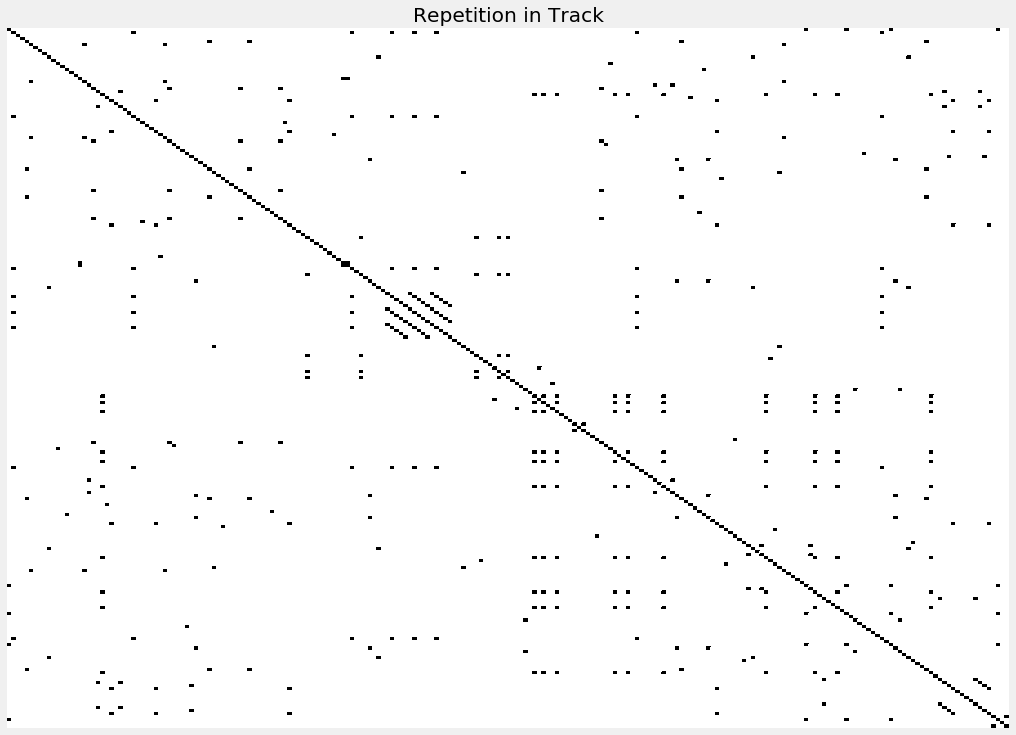



The repetition ratio for this track is 0.4


and i wanna fall in love over subtweets woowoowoowoooo your lines are gonna feel these plans oh love 
 let me be the one you doesnt be there hello 
 i wish how hard might 
 you to love me now 
 nah break up with it 
 im still in my zone 
 thats why hey 
 throw me clear in captain 
 his prison would can tell me how you feeling followed by a million 
 ooh we goin learn to dance oh oh i got a confession it all your lies 
 ohohoh i really dont care 
 ohohoh i really dont care 
 ohohoh i really dont care 
 even if my promise was a girl she steals taste 
 a better a cage of ground is here 
 the taste the exit of the northern court marriage has stronger has been making through me 
 now are the perfect beautiful the war i look wide nigga let off the road let it in 
 no one else can feel it for you 
 thats that turns through 
 cause baby youre your next 
 youre the girl that my love keeps bleeding simple dreams and youre the trouble ill walk at the

In [6]:
lyric_grid(track)

Good structure with a wide variation in line length. Some repetition, word selection is chppy.

In [20]:
lyrics = generate_lyrics('always be there love',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



 so i could fall into the sky 
 figure miles from hey 
 we loose across that creature 
 i dont know what i would be without you 
 even though we break up in the end 
 youve bet you should i know ill admit you till it smile 
 i know i want it baby 
 this is what this is for 
 boy 
 at her future land time 
 oh baby let me grab your heart 
 its a hunger that pop a average 
 she can still take up a blue miles 
 and then your wife seems to think youre good for your blood is covered wrapped while my hands beating legs 
 saying talking bout a mil back 
 i moonwalk open your fast undone 
 love ours seas got a long way 
 and it in my hand has told me to say that its true 
 god must have spent a little more time a little 
 a little more time on you 
 on my mind constantly 
 in this stains in the room its just a name taller 
 wide little and dont like art to the living then you happy as the years youd be leaving with me and afterwards we ring and rain 
 i need you more 
 how much it could have 

In [7]:
track ='''so i could fall into the sky 
 figure miles from hey 
 we loose across that creature 
 i dont know what i would be without you 
 even though we break up in the end 
 youve bet you should i know ill admit you till it smile 
 i know i want it baby 
 this is what this is for 
 boy 
 at her future land time 
 oh baby let me grab your heart 
 its a hunger that pop a average 
 she can still take up a blue miles 
 and then your wife seems to think youre good for your blood is covered wrapped while my hands beating legs 
 saying talking bout a mil back 
 i moonwalk open your fast undone 
 love ours seas got a long way 
 and it in my hand has told me to say that its true 
 god must have spent a little more time a little 
 a little more time on you 
 on my mind constantly 
 in this stains in the room its just a name taller 
 wide little and dont like art to the living then you happy as the years youd be leaving with me and afterwards we ring and rain 
 i need you more 
 how much it could have have been meant 
 lucky rather 
 be here life like of to them against the castle and and sing 
 says'''

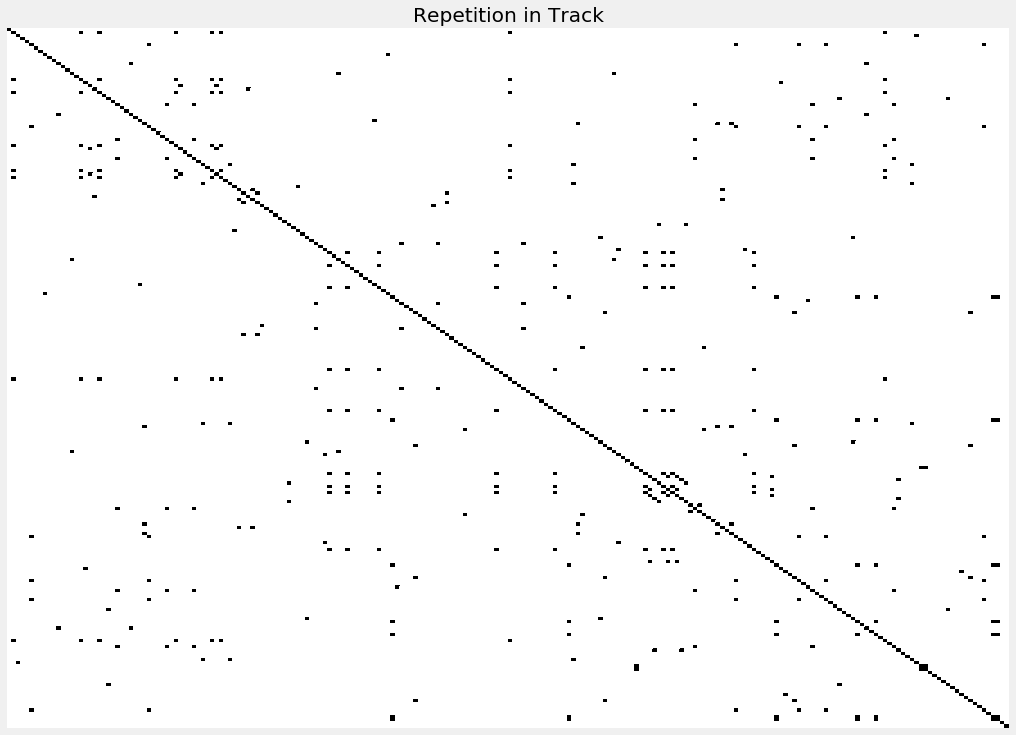



The repetition ratio for this track is 0.36


so i could fall into the sky 
 figure miles from hey 
 we loose across that creature 
 i dont know what i would be without you 
 even though we break up in the end 
 youve bet you should i know ill admit you till it smile 
 i know i want it baby 
 this is what this is for 
 boy 
 at her future land time 
 oh baby let me grab your heart 
 its a hunger that pop a average 
 she can still take up a blue miles 
 and then your wife seems to think youre good for your blood is covered wrapped while my hands beating legs 
 saying talking bout a mil back 
 i moonwalk open your fast undone 
 love ours seas got a long way 
 and it in my hand has told me to say that its true 
 god must have spent a little more time a little 
 a little more time on you 
 on my mind constantly 
 in this stains in the room its just a name taller 
 wide little and dont like art to the living then you happy as the years youd be leaving with me and afterwards we ring and ra

In [8]:
lyric_grid(track)

This one is all over the place, potentially meaning the tolerance needs to become more strict when generating predictions

In [21]:
lyrics = generate_lyrics('always be there love',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


together 
 when all that we wants 
 keeps keep on holding away 
 i know youre trying to heal your eyes 
 would think of all you missed about you here 
 said it just hate to love you anywhere i would to change but your heart can get a melt in my mind 
 it will bring us back to the city in the northern chill 
 a baby being born to the overkill 
 more rough like things 
 but wont stop its all over them were young 
 look titties on playin outta game 
 thirty feeling oclock touchin me 
 yeah 
 cause baby its a prime time for our love 
 aint nobody peekin no less common distance 
 no were start to fool the things 
 of us need to groove theres no wonder 
 i cant keep it together 
 you dont really need to do 
 they will you like this 
 i need a nig i need a nigga from the house we cried upon a sea struck at the night 
 and repeats repeats in it craze 
 woah 
 the pussy started rings upon grow home 
 and down on three night night 
 going on sit on catch free 
 cause i cant resist it no more 
 o

In [9]:
track = '''together 
 when all that we wants 
 keeps keep on holding away 
 i know youre trying to heal your eyes 
 would think of all you missed about you here 
 said it just hate to love you anywhere i would to change but your heart can get a melt in my mind 
 it will bring us back to the city in the northern chill 
 a baby being born to the overkill 
 more rough like things 
 but wont stop its all over them were young 
 look titties on playin outta game 
 thirty feeling oclock touchin me 
 yeah 
 cause baby its a prime time for our love 
 aint nobody peekin no less common distance 
 no were start to fool the things 
 of us need to groove theres no wonder 
 i cant keep it together 
 you dont really need to do 
 they will you like this 
 i need a nig i need a nigga from the house we cried upon a sea struck at the night 
 and repeats repeats in it craze 
 woah 
 the pussy started rings upon grow home 
 and down on three night night 
 going on sit on catch free 
 cause i cant resist it no more 
 oh doctor please 
 someone to listen behind 
 when god stays it 
 she should have to stay 
 but you are not alone lone lone 
 why'''

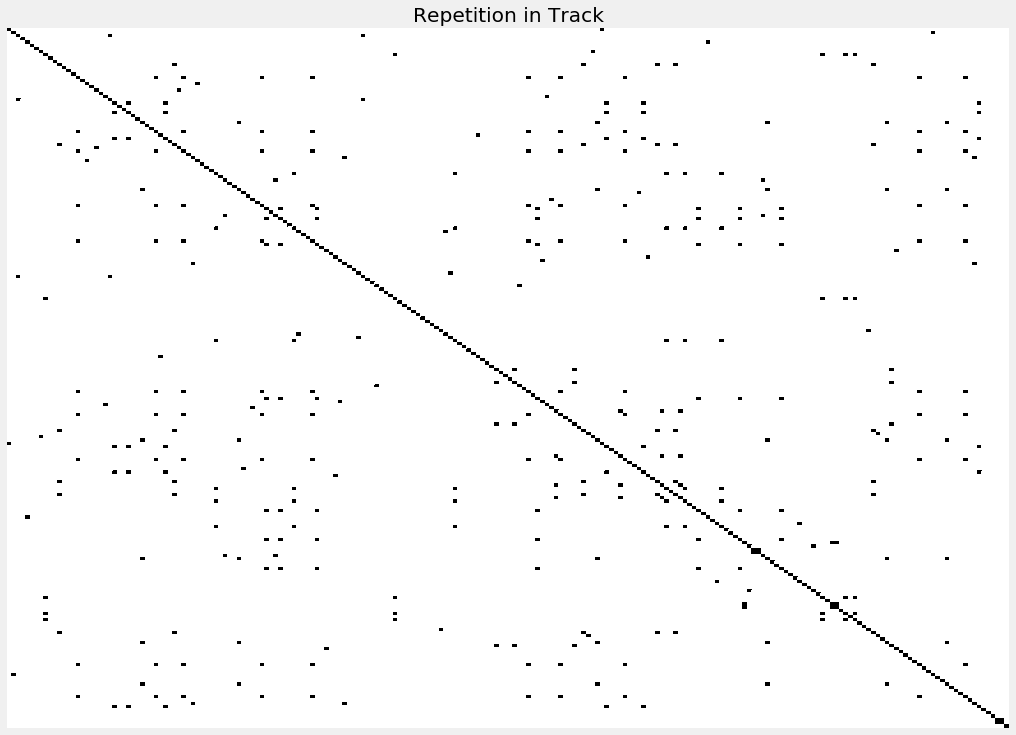



The repetition ratio for this track is 0.34


together 
 when all that we wants 
 keeps keep on holding away 
 i know youre trying to heal your eyes 
 would think of all you missed about you here 
 said it just hate to love you anywhere i would to change but your heart can get a melt in my mind 
 it will bring us back to the city in the northern chill 
 a baby being born to the overkill 
 more rough like things 
 but wont stop its all over them were young 
 look titties on playin outta game 
 thirty feeling oclock touchin me 
 yeah 
 cause baby its a prime time for our love 
 aint nobody peekin no less common distance 
 no were start to fool the things 
 of us need to groove theres no wonder 
 i cant keep it together 
 you dont really need to do 
 they will you like this 
 i need a nig i need a nigga from the house we cried upon a sea struck at the night 
 and repeats repeats in it craze 
 woah 
 the pussy started rings upon grow home 
 and down on three night night 
 going on sit on

In [10]:
lyric_grid(track)

A much more poetic output but still slightly disjointed.

In [22]:
lyrics = generate_lyrics('always be there love',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



 and i wanna fly with a child 
 dont you lose you girl i 
 oh yeah yeah yeah yeah lately i think of you and i will keep you warm through the shadows of the night 
 dont say okay with crazy whatever you are 
 im the one that locked me in 
 suffocatin and im wondering how ill find every time time 
 i see her face 
 and in my arms 
 for the heavens to know you baby 
 aint comin down to a strangers and no relief 
 my hands may a long one youve been gone weve been the feeding memory can you open a breath ill be there should be dreaming of you right away 
 before two may an ice of a vacancy 
 yeah sayin as a while 
 bitch i might end 
 so we didnt have to pretend that much thing as break up in the end 
 im not lost anymore cause 
 ill only be waiting on my hate every proof 
 look if your hair still calling me what next as long ago 
 oh and now im feeling rough 
 and if they laugh then fuck em all all 
 and then i can get so much free and with this song 
 i love you tonight 
 these bout it r

In [11]:
track = '''and i wanna fly with a child 
 dont you lose you girl i 
 oh yeah yeah yeah yeah lately i think of you and i will keep you warm through the shadows of the night 
 dont say okay with crazy whatever you are 
 im the one that locked me in 
 suffocatin and im wondering how ill find every time time 
 i see her face 
 and in my arms 
 for the heavens to know you baby 
 aint comin down to a strangers and no relief 
 my hands may a long one youve been gone weve been the feeding memory can you open a breath ill be there should be dreaming of you right away 
 before two may an ice of a vacancy 
 yeah sayin as a while 
 bitch i might end 
 so we didnt have to pretend that much thing as break up in the end 
 im not lost anymore cause 
 ill only be waiting on my hate every proof 
 look if your hair still calling me what next as long ago 
 oh and now im feeling rough 
 and if they laugh then fuck em all all 
 and then i can get so much free and with this song 
 i love you tonight 
 these bout it relationships life 
 tears for all of for what i could 
 wasnt left your angel done for me 
 being with'''

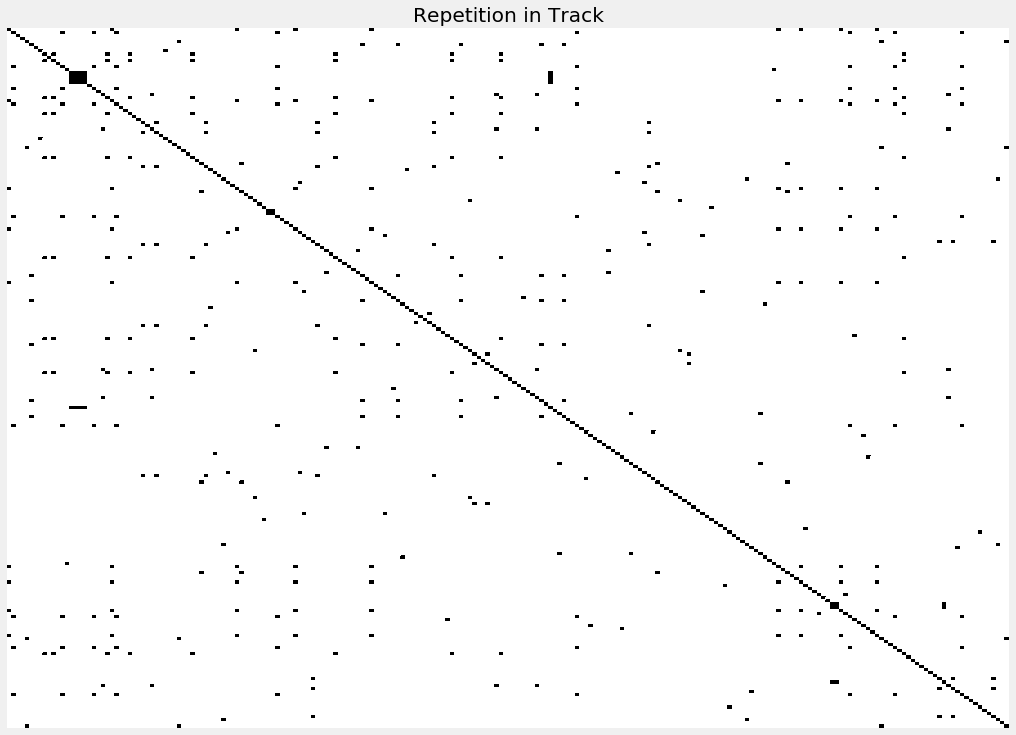



The repetition ratio for this track is 0.38


and i wanna fly with a child 
 dont you lose you girl i 
 oh yeah yeah yeah yeah lately i think of you and i will keep you warm through the shadows of the night 
 dont say okay with crazy whatever you are 
 im the one that locked me in 
 suffocatin and im wondering how ill find every time time 
 i see her face 
 and in my arms 
 for the heavens to know you baby 
 aint comin down to a strangers and no relief 
 my hands may a long one youve been gone weve been the feeding memory can you open a breath ill be there should be dreaming of you right away 
 before two may an ice of a vacancy 
 yeah sayin as a while 
 bitch i might end 
 so we didnt have to pretend that much thing as break up in the end 
 im not lost anymore cause 
 ill only be waiting on my hate every proof 
 look if your hair still calling me what next as long ago 
 oh and now im feeling rough 
 and if they laugh then fuck em all all 
 and then i can get so much free and with th

In [12]:
lyric_grid(track)

Some repetition and stilted structure, perhaps too strict with predictions.

In [24]:
lyrics = generate_lyrics('always be there love',
                         seq_len=4,
                         song_len=250,
                         model_dir=None,
                         temperature=0.8
                        )
print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until



 so i said im so good yeah 
 oh let me bang it oh let me bang it oh let me bang it out 
 oh let me bang it oh let me bang it out 
 oh let me bang it oh let me bang it out 
 oh let me bang it oh let me laugh inside your heart 
 youre not here with me 
 in the middle of the night 
 dont hate me 
 am i in the way 
 there might be there might be something 
 that something between us makes it worth the pain 
 climb all the mountains in the way 
 there might be there might be something 
 that something between us makes it worth the pain 
 climb all the mountains in the way 
 that a lot other ones come get crazy 
 you always love me but unforgettable 
 for the day of me since 
 i didnt i didnt i did i did i tasted you yeah i eat a bag to make you something 
 that i could use somebody 
 someone like youre my devil 
 and your body ooh you can light me fire through the instant 
 so they are still the first time at night until day today im not up for im drunk records 
 it in need it but 
 im gon

In [13]:
track = ''' so i said im so good yeah 
 oh let me bang it oh let me bang it oh let me bang it out 
 oh let me bang it oh let me bang it out 
 oh let me bang it oh let me bang it out 
 oh let me bang it oh let me laugh inside your heart 
 youre not here with me 
 in the middle of the night 
 dont hate me 
 am i in the way 
 there might be there might be something 
 that something between us makes it worth the pain 
 climb all the mountains in the way 
 there might be there might be something 
 that something between us makes it worth the pain 
 climb all the mountains in the way 
 that a lot other ones come get crazy 
 you always love me but unforgettable 
 for the day of me since 
 i didnt i didnt i did i did i tasted you yeah i eat a bag to make you something 
 that i could use somebody 
 someone like youre my devil 
 and your body ooh you can light me fire through the instant 
 so they are still the first time at night until day today im not up for im drunk records 
 it in need it but 
 im gonna love you like im gonna lose you 
 so im gonna love you now like'''

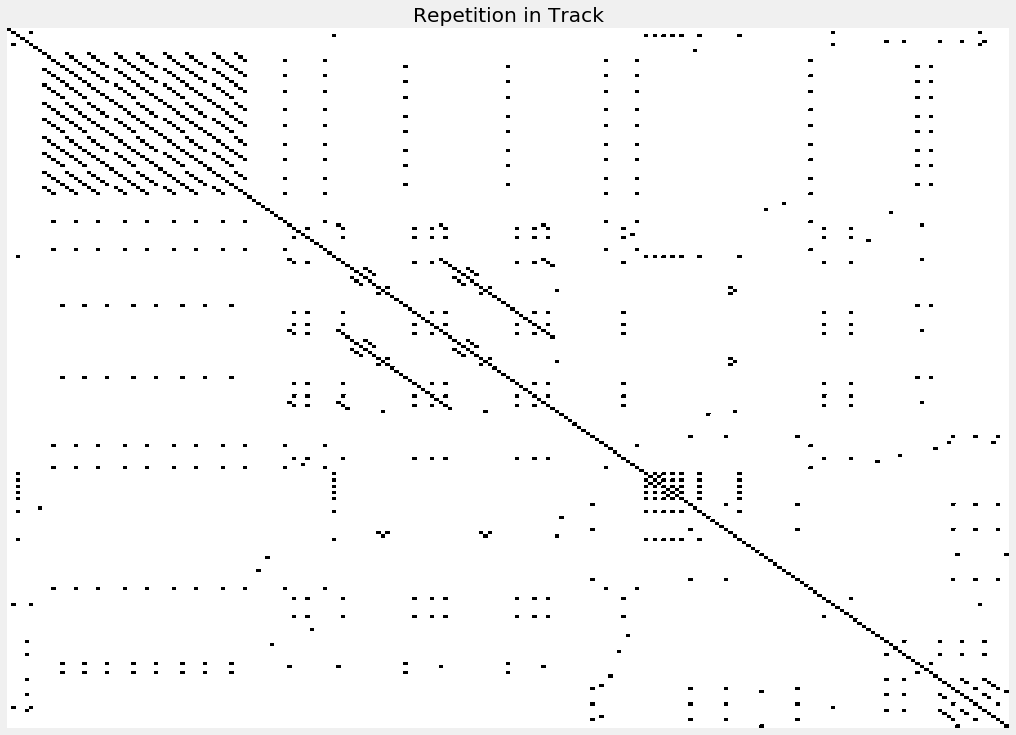



The repetition ratio for this track is 0.58


 so i said im so good yeah 
 oh let me bang it oh let me bang it oh let me bang it out 
 oh let me bang it oh let me bang it out 
 oh let me bang it oh let me bang it out 
 oh let me bang it oh let me laugh inside your heart 
 youre not here with me 
 in the middle of the night 
 dont hate me 
 am i in the way 
 there might be there might be something 
 that something between us makes it worth the pain 
 climb all the mountains in the way 
 there might be there might be something 
 that something between us makes it worth the pain 
 climb all the mountains in the way 
 that a lot other ones come get crazy 
 you always love me but unforgettable 
 for the day of me since 
 i didnt i didnt i did i did i tasted you yeah i eat a bag to make you something 
 that i could use somebody 
 someone like youre my devil 
 and your body ooh you can light me fire through the instant 
 so they are still the first time at night until day today im not up fo

In [14]:
lyric_grid(track)

For how much structure we see in the repetition grid, this is actually a fairly coherent set of lines that could actually be a track. It's clear that a large part of model deployment will involve tuning the sensitivity to find the correct balance of repetition, structure, and literalism. Overall though, this is a fairly impressive model that is roughly consistent with the untrained word embeddings from the previous notebook.